In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import pandas as pd
import tensorflow as tf
from tqdm import tqdm , tqdm_notebook
import numpy as np
import category_encoders as ce
import re
from copy import deepcopy
from MI import Gene_Missing
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/home/advice/Python/SR/Custom/')
from utility import *
from Activations import *
from pyprnt import prnt as PrettyPrint
from autoimpute.utils import md_pattern, proportions
from autoimpute.visuals import plot_md_locations, plot_md_percent
from autoimpute.visuals import plot_imp_dists, plot_imp_boxplots
from autoimpute.visuals import plot_imp_swarm, plot_imp_strip
from autoimpute.visuals import plot_imp_scatter

# autoimpute imports - imputations & analysis
from autoimpute.imputations import MultipleImputer


    사용하면 좋은 패키지
    st / train_validation_test_split / cat2dict / code2cat / colorlist / onehotencoding / roccurve  / ProbDensity
    pycm import *  
    ConfusionMatrix(actual_vector=``test_y``, predict_vector= ``pred`` ) 
    사용하면 통계량값 다 얻을 수 있음
    


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RAW_ = pd.read_csv("/home/advice/Python/SR/Data/Churn.csv")
usecols = RAW_.columns.tolist()
print(RAW_.shape)
print(RAW_.dropna().shape)
#RAW_ = RAW_.dropna().reset_index(drop=True)
RAW_.head()

(3333, 21)
(3333, 21)


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
st(RAW_)

<class 'pandas.core.frame.DataFrame'> : dimension of (3333, 21)
Index: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ...  : int64 

state                    object  [[KS, OH, NJ, OK, AL, MA, MO, LA, WV, IN, RI, ...
account length            int64  [[128, 107, 137, 84, 75, 118, 121, 147, 117, 1...
area code                 int64                                  [[415, 408, 510]]
phone number             object  [[382-4657, 371-7191, 358-1921, 375-9999, 330-...
international plan       object                                        [[no, yes]]
voice mail plan          object                                        [[yes, no]]
number vmail messages     int64  [[25, 26, 0, 24, 37, 27, 33, 39, 30, 41, 28, 3...
total day minutes       float64  [[265.1, 161.6, 243.4, 299.4, 166.7, 223.4, 21...
total day calls           int64  [[110, 123, 114, 71, 113, 98, 88, 79, 97, 84, ...
total day charge        float64  [[45.07, 27.47, 41.38, 50.9, 28.34, 37.98, 37....
total eve minutes       float64  [[197.4, 195.5, 121.2,

In [4]:
PrettyPrint(RAW_.columns.tolist())

┌──┬──────────────────────┐
│0 │state                 │
│1 │account length        │
│2 │area code             │
│3 │phone number          │
│4 │international plan    │
│5 │voice mail plan       │
│6 │number vmail messages │
│7 │total day minutes     │
│8 │total day calls       │
│9 │total day charge      │
│10│total eve minutes     │
│11│total eve calls       │
│12│total eve charge      │
│13│total night minutes   │
│14│total night calls     │
│15│total night charge    │
│16│total intl minutes    │
│17│total intl calls      │
│18│total intl charge     │
│19│customer service calls│
│20│churn                 │
└──┴──────────────────────┘


In [5]:
RAW_["churn"] = RAW_["churn"].astype(str)
RAW_["area code"] = RAW_["area code"].astype(str)

In [6]:
notuse = ['account length', 'phone number']
for col in notuse :
    usecols.remove(col)

In [7]:
RAW = RAW_[usecols]
RAW.shape

(3333, 19)

In [8]:
RAW.head()

,state,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [9]:
obj_col = RAW.select_dtypes("object").columns.tolist()
ord_col = RAW.select_dtypes("int").columns.tolist()
num_col = RAW.select_dtypes("float").columns.tolist()
print(obj_col)
assert len(usecols) == len(obj_col + ord_col + num_col)

['state', 'area code', 'international plan', 'voice mail plan', 'churn']


In [10]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler(feature_range=(-1,1)) # 
minmax.feature_range

(-1, 1)

## Missing 관련 정보 정리하기

In [11]:
%load_ext autoreload
%autoreload 2
from MissInfo import MissInfo
missinfo = MissInfo(RAW , obj_col , num_col , ord_col , minmax)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
minmax.feature_range

(-1, 1)

In [13]:
p_miss = 0.2
missinfo.fit()
trainX , testX , trainM , testM = missinfo.DL_train_test_split(0.7 ,
                                                               p_miss= p_miss ,
                                                               smooth = False , 
                                                               degree = 0.1 , 
                                                               numpy= False )

Missing 정보 함축
74


In [14]:
trainX.columns

Index(['state_KS', 'state_OH', 'state_NJ', 'state_OK', 'state_AL', 'state_MA',
       'state_MO', 'state_LA', 'state_WV', 'state_IN', 'state_RI', 'state_IA',
       'state_MT', 'state_NY', 'state_ID', 'state_VT', 'state_VA', 'state_TX',
       'state_FL', 'state_CO', 'state_AZ', 'state_SC', 'state_NE', 'state_WY',
       'state_HI', 'state_IL', 'state_NH', 'state_GA', 'state_AK', 'state_MD',
       'state_AR', 'state_WI', 'state_OR', 'state_MI', 'state_DE', 'state_UT',
       'state_CA', 'state_MN', 'state_SD', 'state_NC', 'state_WA', 'state_NM',
       'state_NV', 'state_DC', 'state_KY', 'state_ME', 'state_MS', 'state_TN',
       'state_PA', 'state_CT', 'state_ND', 'area code_415', 'area code_408',
       'area code_510', 'international plan_no', 'international plan_yes',
       'voice mail plan_yes', 'voice mail plan_no', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
     

In [15]:
miss_info = missinfo.information()

In [16]:
#np.set_printoptions(threshold=sys.maxsize)

In [17]:
missinfo.summary()

,state_KS,state_OH,state_NJ,state_OK,state_AL,state_MA,state_MO,state_LA,state_WV,state_IN,...,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn_False,churn_True
train,468.0000,468.0000,468.0000,468.0000,468.0000,468.0000,468.0000,468.0000,468.0000,468.0000,...,483.00000,486.000000,483.00000,447.000000,444.000000,486.000000,467.000000,438.000000,464.000000,464.000000
test,206.0000,206.0000,206.0000,206.0000,206.0000,206.0000,206.0000,206.0000,206.0000,206.0000,...,205.00000,199.000000,195.00000,186.000000,223.000000,190.000000,209.000000,191.000000,191.000000,191.000000
sum,674.0000,674.0000,674.0000,674.0000,674.0000,674.0000,674.0000,674.0000,674.0000,674.0000,...,688.00000,685.000000,678.00000,633.000000,667.000000,676.000000,676.000000,629.000000,655.000000,655.000000
total,3333.0000,3333.0000,3333.0000,3333.0000,3333.0000,3333.0000,3333.0000,3333.0000,3333.0000,3333.0000,...,3333.00000,3333.000000,3333.00000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
missing rate,20.2200,20.2200,20.2200,20.2200,20.2200,20.2200,20.2200,20.2200,20.2200,20.2200,...,20.64000,20.550000,20.34000,18.990000,20.010000,20.280000,20.280000,18.870000,19.650000,19.650000
missing_train_mean,0.2006,0.2006,0.2006,0.2006,0.2006,0.2006,0.2006,0.2006,0.2006,0.2006,...,0.20703,0.208315,0.20703,0.191599,0.190313,0.208315,0.200171,0.187741,0.198886,0.198886
missing_test_mean,0.2060,0.2060,0.2060,0.2060,0.2060,0.2060,0.2060,0.2060,0.2060,0.2060,...,0.20500,0.199000,0.19500,0.186000,0.223000,0.190000,0.209000,0.191000,0.191000,0.191000


In [18]:
PrettyPrint(list(miss_info.keys()))

┌──┬────────────────────────────┐
│0 │X                           │
│1 │original_column             │
│2 │scaler                      │
│3 │obj_col                     │
│4 │ord_col                     │
│5 │num_col                     │
│6 │ce_replace                  │
│7 │obj_idx                     │
│8 │ord_idx                     │
│9 │ce_encoder                  │
│10│columns                     │
│11│obj_info                    │
│12│obj_range                   │
│13│cat_num_idx_info            │
│14│obj_weight_info             │
│15│ori_missing_matrix          │
│16│ori_transform_missing_matrix│
│17│ori_raw_pd                  │
│18│ori_transform_pd            │
└──┴────────────────────────────┘


In [19]:
PrettyPrint(missinfo.info["obj_info"])

┌──────────────────┬──────────────┐
│state             │┌─────────┬──┐│
│                  ││start_idx│0 ││
│                  ││n        │51││
│                  │└─────────┴──┘│
│area code         │┌─────────┬──┐│
│                  ││start_idx│51││
│                  ││n        │3 ││
│                  │└─────────┴──┘│
│international plan│┌─────────┬──┐│
│                  ││start_idx│54││
│                  ││n        │2 ││
│                  │└─────────┴──┘│
│voice mail plan   │┌─────────┬──┐│
│                  ││start_idx│56││
│                  ││n        │2 ││
│                  │└─────────┴──┘│
│churn             │┌─────────┬──┐│
│                  ││start_idx│72││
│                  ││n        │2 ││
│                  │└─────────┴──┘│
└──────────────────┴──────────────┘


In [20]:
ck = missinfo.ori_missing[0,:].astype(bool)
missinfo.ori_raw_pd.loc[:,ck].head(1)

""
0


In [21]:
ck = missinfo.ori_transform_missing[0,:].astype(bool)
missinfo.ori_transform_pd.loc[:,ck].head(1)

""
0


In [22]:
%load_ext autoreload
%autoreload 2
from Tensorflow_GainMI import Missing_GAIN as MG
from Tensorflow_AutoEncMI import Missing_AE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
PrettyPrint(dict(zip(miss_info["original_column"] ,
                     miss_info["cat_num_idx_info"])))

┌──────────────────────┬──┐
│state                 │0 │
│area code             │51│
│international plan    │54│
│voice mail plan       │56│
│number vmail messages │58│
│total day minutes     │59│
│total day calls       │60│
│total day charge      │61│
│total eve minutes     │62│
│total eve calls       │63│
│total eve charge      │64│
│total night minutes   │65│
│total night calls     │66│
│total night charge    │67│
│total intl minutes    │68│
│total intl calls      │69│
│total intl charge     │70│
│customer service calls│71│
│churn                 │72│
└──────────────────────┴──┘


In [24]:
## Metric Loss 없는게 더 잘 됨
Auto = Missing_AE(enc_dim = [40 , 35 ,  25 , 20]  , 
                  dec_dim = [25 , 35 , 45 , 55] ,
                  missing_info = miss_info , 
                  save_info_path= "./Churn_AE_missinfo_{}.pkl".format(p_miss) , 
                  save_model_path= './Churn_CAT_AE_{}/Model'.format(p_miss)  , gpu = 1) 
mb_size = 256
Auto.fit(trainX , trainM ,testX , testM , 
         mb_size , epoch = 10000,
         Enc_act = tf_mish ,
         Dec_act = tf_mish ,
         weight_regularizer = 0,
         patience = 10 ,
         cutoff = 1e-10,
         SN = False , 
         lr = 0.003 ,
         MetricLoss = False , 
        )

./Churn_AE_missinfo_0.2.pkl에 missing info 저장
Instructions for updating:
Colocations handled automatically by placer.
Onehot Shape : [74] --> Embedding Shape : [48] 
Input Shape : (?, 48)
Instructions for updating:
Use tf.cast instead.
                        모델피팅                        


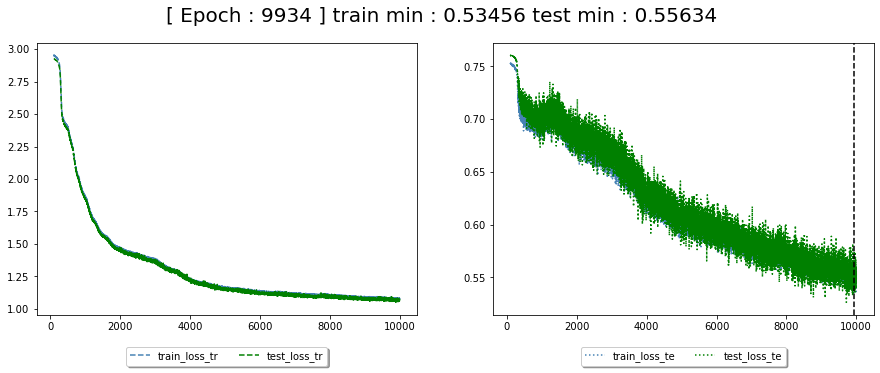

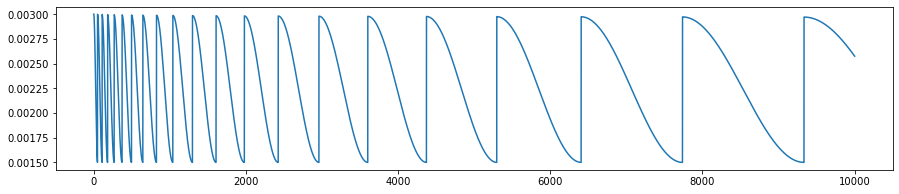

      학습완료 


In [25]:
Auto.train()

In [26]:
mg = MG(gen_dim = [120,110,90, 75]  , 
        dis_dim = [120,110,90, 80] , 
        missing_info = miss_info , 
        save_info_path= "./Churn_GAIN_info_{}.pkl".format(p_miss),
        save_model_path= './Churn_CAT_GAIN_{}/Model'.format(p_miss),
        gpu = 1 , )
mb_size = 256
mg.fit(trainX , trainM ,
       testX , testM , 
       mb_size , 
       hint = 0.9 ,
       Gact = tf_mish , 
       Dact = tf_mish , 
       epoch = 10000, 
       alpha = 3 , 
       SN = False ,
       lr = 0.001 , 
       weight_regularizer = 0 ,
       max_norm = False , 
       patience = 10 ,
       cutoff = 1e-8,
      )

./Churn_GAIN_info_0.2.pkl에 missing info 저장
Instructions for updating:
Use tf.cast instead.


2019-11-15 22:55:31 | From /root/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:209: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Columns : state                     | multiclass | [51]
Columns : area code                 | multiclass | [3]
Columns : international plan        | binary     | [2]
Columns : voice mail plan           | binary     | [2]
Columns : number vmail messages     | mse        | [1]
Columns : total day minutes         | mse        | [1]
Columns : total day calls           | mse        | [1]
Columns : total day charge          | mse        | [1]
Columns : total eve minutes         | mse        | [1]
Columns : total eve calls           | mse        | [1]
Columns : total eve charge          | mse        | [1]
Columns : total night minutes       | mse        | [1]
Columns : total night calls         | mse        | [1]
Columns : total night charge        | mse        | [1]
Columns : total intl minutes        | mse        | [1]
Columns : total intl calls          | mse        | [1]
Columns : total intl charge         | mse        | [1]
Columns : customer service calls    | mse        | [1]
Columns :

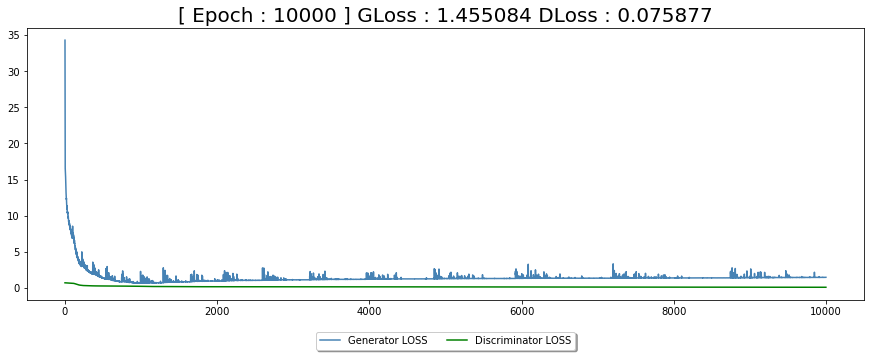

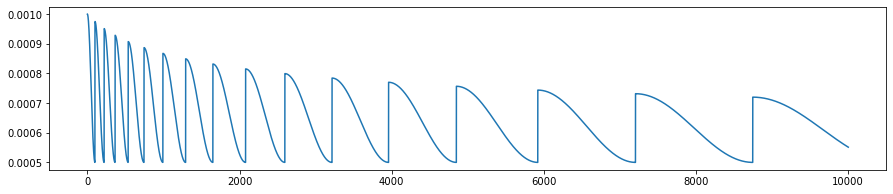

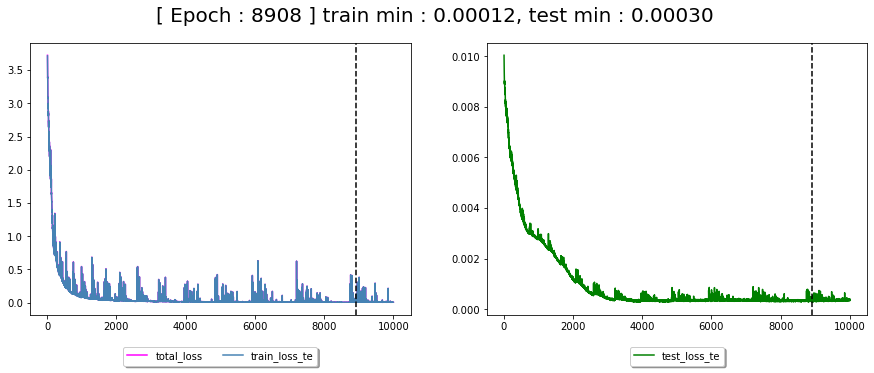

      학습완료 


In [27]:
mg.train()

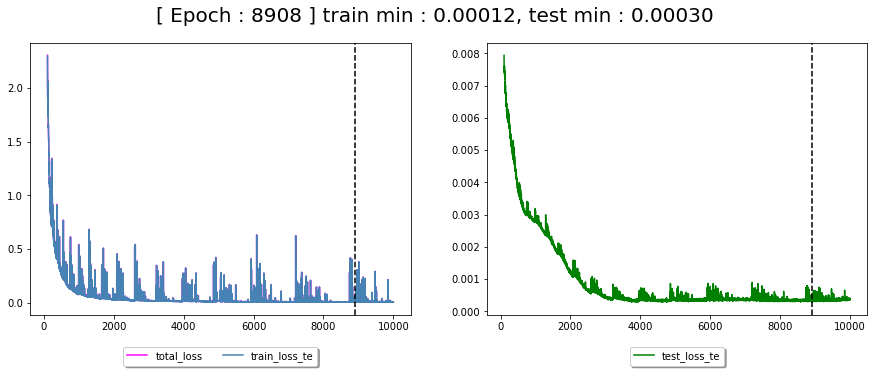

In [28]:
mg.metric_plot(idx = 100)

In [29]:
missing_matrix_RAW = miss_info["ori_transform_missing_matrix"]
missing_matrix_ori_RAW = miss_info["ori_missing_matrix"]
missing_RAW = miss_info["ori_transform_pd"]
missing_data = deepcopy(missing_RAW.values)
missing_data[missing_matrix_RAW == 1] = np.nan

In [30]:
pd.DataFrame(missing_data , columns= miss_info["columns"]).head(2)

,state_KS,state_OH,state_NJ,state_OK,state_AL,state_MA,state_MO,state_LA,state_WV,state_IN,...,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn_False,churn_True
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.085733,0.191501,-0.183099,0.191871,0.0,-0.7,0.00000,-0.777778,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.075380,0.243679,-0.014085,0.244471,NaN,-0.7,0.37037,-0.777778,NaN,NaN


In [31]:
AE_load_data = Auto.load_impute(save_file = './Churn_CAT_AE_{}/Model.meta'.format(p_miss) , 
                                file= "./Churn_CAT_AE_{}/".format(p_miss) ,
                                Data = missing_data , 
                                Missing = missing_matrix_RAW)

Instructions for updating:
Use standard file APIs to check for files with this prefix.


| 2019-11-16 02:18:02 | From /root/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./Churn_CAT_AE_0.2/Model


| 2019-11-16 02:18:02 | Restoring parameters from ./Churn_CAT_AE_0.2/Model


In [32]:
MG_load_data = mg.load_impute(
    save_file = './Churn_CAT_GAIN_{}/Model.meta'.format(p_miss) , 
    file= "./Churn_CAT_GAIN_{}/".format(p_miss) ,
    Data = missing_data , 
    Missing = missing_matrix_RAW
                )

INFO:tensorflow:Restoring parameters from ./Churn_CAT_GAIN_0.2/Model


| 2019-11-16 02:18:18 | Restoring parameters from ./Churn_CAT_GAIN_0.2/Model


In [33]:
RAW_TRANS = Auto.transform(missing_RAW.values , num_inv_scaler = True)

In [34]:
# Auto.object_comparision(RAW_TRANS , AE_load_data)
# mg.object_comparision(RAW_TRANS , MG_load_data)

## Numerical 변수만 가지고 RMSE 비교

In [35]:
print("AutoEncoder  : " ,  Auto.metric(RAW_TRANS , AE_load_data , 
                                     missing_matrix_RAW , standardize = False ,
                                       metric_type ="rmse" , 
                                     kf = None ) )
print('GAIN : ' , mg.metric(RAW_TRANS , MG_load_data ,
                            missing_matrix_RAW , standardize = False,
                            metric_type ="rmse" , 
                            kf = None
                         )  )

AutoEncoder  :  6.039803359746384
GAIN :  0.6633820940278587


In [36]:
print("AutoEncoder  : " ,  Auto.metric(RAW_TRANS , AE_load_data , 
                                       missing_matrix_RAW , standardize = False ,
                                       metric_type ="nrmse" , 
                                     kf = None ) )
print('GAIN : ' , mg.metric(RAW_TRANS , MG_load_data ,
                            missing_matrix_RAW , standardize = False,
                            metric_type ="nrmse" , 
                            kf = None
                         )  )

AutoEncoder  :  0.1285383672252424
GAIN :  0.0014626193981985814


In [37]:
cc = RAW_TRANS.columns.tolist()
missing = pd.DataFrame(missing_matrix_RAW, columns =  miss_info["columns"])
for col in RAW_TRANS.columns.tolist() :
    if col in obj_col :
        cc.remove(col)

In [38]:
pd.concat([AE_load_data[cc].head(2) ,
           MG_load_data[cc].head(2)] )

,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,25.000000,265.099996,110.000001,45.070001,197.4,99.0,16.78,244.700001,91.000001,11.01,10.000000,3.0,2.7,1.0
1,30.131419,161.600000,123.000001,27.470000,195.5,103.0,16.62,254.400001,103.000000,11.45,12.153680,3.0,3.7,1.0
0,25.000000,265.099996,110.000001,45.070001,197.4,99.0,16.78,244.700001,91.000001,11.01,10.000000,3.0,2.7,1.0
1,27.089754,161.600000,123.000001,27.470000,195.5,103.0,16.62,254.400001,103.000000,11.45,13.570136,3.0,3.7,1.0


In [39]:
raw = RAW_TRANS[cc]
mis = missing[cc]
missing_data = deepcopy(raw)
missing_matrix = deepcopy(mis)

In [40]:
missing_data[(missing_matrix == 1).values] = np.nan
pd.concat([missing_matrix.head(2) , missing_data.head(2) , raw.head(2)])

,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,1.0,0.0,0.0,0.0
0,25.0,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.7,1.0
1,NaN,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,NaN,3.0,3.7,1.0
0,25.0,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.7,1.0
1,26.0,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.7,1.0


```
from sklearn.impute import SimpleImputer
missing_matrix = deepcopy(miss_info["ori_missing_matrix"])
raw = deepcopy(miss_info["ori_raw_pd"])
mask = pd.DataFrame(missing_matrix, columns = raw.columns.tolist())
T = deepcopy(raw)
raw[(mask == 1).values] = np.nan
X = deepcopy(raw)
cat_impute = SimpleImputer(strategy="most_frequent")
X[objcols] = cat_impute.fit_transform( X[objcols])
pd_obj = X[objcols]
X = X[cc]
T = T[cc]
from missingpy import MissForest
from Imputation import Evaluate as EV
from sklearn.model_selection import KFold
missing_matrix = deepcopy(miss_info["ori_missing_matrix"])
raw[missing_matrix == 1] = np.nan
obj_col = miss_info["obj_col"]
cat_var = [idx for idx , i in enumerate(miss_info["original_column"]) if i in obj_col]
MI = MissForest(verbose = 0, 
                n_jobs  = -1 ,max_depth=5).fit_transform(X = raw.values , 
                                                         cat_vars= cat_var)
kf = KFold(n_splits = 7) # Define the split - into 2 folds 
kf.get_n_splits(missing_data)
Imputation_BenchMark = EV(X = missing_data , 
                          T = raw , 
                          kf = kf ,
                          mask= missing_matrix ,
                          miss_info= miss_info , 
                          algo =\
                          ["mean", "MissForest","median" ,"knn", "mode" , 
                          "MICE"  , "EM" , ])
```

```
from renom.utility import completion
objcols = miss_info["obj_col"]
missing_matrix = deepcopy(miss_info["ori_missing_matrix"])
raw = deepcopy(miss_info["ori_raw_pd"])
raw[cc] =miss_info["scaler"].inverse_transform(raw[cc])
change = raw["area code"].unique().tolist()
to = {}
re = {}
for col in change :
    to[str(col)] = "A"+ str(col)
    re["A"+str(col)] = str(col)
raw.replace({'area code' : to }, inplace= True)
raw[missing_matrix==1]= np.nan
X_filled = completion(raw.values  , mode="mice", impute_type="col")
imputed_mice = pd.DataFrame(X_filled, columns = raw.columns.tolist())
imputed_mice.replace({'area code' : re }, inplace= True)
```

In [41]:
from Imputation import Evaluate as EV
from sklearn.model_selection import KFold
kf = KFold(n_splits = 7) # Define the split - into 2 folds 
kf.get_n_splits(missing_data)
objcols = miss_info["obj_col"]
cc = RAW_TRANS.columns.tolist()
for col in RAW_TRANS.columns.tolist() :
    if col in obj_col :
        cc.remove(col)
        
raw = deepcopy(RAW_TRANS)
missing_matrix = deepcopy(missing_matrix_ori_RAW)

Imputation_BenchMark = EV(T = raw , 
                          kf = kf ,
                          mask= missing_matrix ,
                          obj = objcols ,
                          notobj = cc , 
                          target = "churn" , 
                          miss_info= miss_info , 
                          algo =\
                          ["MICE"  ,"mean","MissForest", 
                           "median" ,"knn", "mode" , "EM" ])

In [42]:
# Imputation_BenchMark = EV(T = None , 
#                           kf = None ,
#                           mask= None ,
#                           obj = None ,
#                           notobj = None , 
#                           target = None , 
#                           miss_info= None , 
#                           algo =None)
# Imputation_BenchMark.load_result("./Churn_Vis/Churn_Info.pkl.pkl")

In [43]:
Imputation_BenchMark.evaluate(standardize = False)

MICE 진행중....
[MICE] Completing matrix with shape (476, 19)[MICE] Completing matrix with shape (476, 19)
[MICE] Completing matrix with shape (476, 19)
[MICE] Completing matrix with shape (476, 19)
[MICE] Completing matrix with shape (476, 19)
[MICE] Completing matrix with shape (476, 19)
[MICE] Completing matrix with shape (477, 19)

[MICE] Starting imputation round 10/60, elapsed time 119.252
[MICE] Starting imputation round 10/60, elapsed time 121.225
[MICE] Starting imputation round 10/60, elapsed time 123.026
[MICE] Starting imputation round 10/60, elapsed time 123.309
[MICE] Starting imputation round 10/60, elapsed time 124.768
[MICE] Starting imputation round 10/60, elapsed time 131.902
[MICE] Starting imputation round 10/60, elapsed time 135.129
[MICE] Starting imputation round 20/60, elapsed time 249.515
[MICE] Starting imputation round 20/60, elapsed time 255.546
[MICE] Starting imputation round 20/60, elapsed time 258.149
[MICE] Starting imputation round 20/60, elapsed time 25

In [44]:
Imputation_BenchMark.append_algo(name ="GAIN", 
                                 rmse = mg.metric(RAW_TRANS , MG_load_data  ,
                                           missing_matrix_RAW, standardize = False, 
                                           kf = kf.split(missing_data) ,
                                           metric_type = "rmse"
                                          ) , 
                                 nrmse = mg.metric(RAW_TRANS , MG_load_data  ,
                                           missing_matrix_RAW, standardize = False, 
                                           kf = kf.split(missing_data) ,
                                           metric_type = "nrmse"
                                          ) , 
                                 imputed= MG_load_data)
Imputation_BenchMark.append_algo(name = "AutoEncoder", 
                                 rmse = Auto.metric(RAW_TRANS , AE_load_data , 
                                           missing_matrix_RAW, standardize = False ,
                                           kf = kf.split(missing_data) , 
                                           metric_type = "rmse"
                                          ) , 
                                 nrmse = Auto.metric(RAW_TRANS , AE_load_data , 
                                           missing_matrix_RAW, standardize = False ,
                                           kf = kf.split(missing_data) , 
                                           metric_type = "nrmse"
                                          ) , 
                                 imputed= AE_load_data)

GAIN 업데이트
AutoEncoder 업데이트


In [45]:
Imputation_BenchMark.Outcome()
Imputation_BenchMark.Predict_Comparision()

 가공 MICE
 가공 mean Category Most Common Imputation
 가공 MissForest
 가공 median Category Most Common Imputation
 가공 knn Category Most Common Imputation
 가공 mode Category Most Common Imputation
 가공 EM Category Most Common Imputation
 가공 GAIN
 가공 AutoEncoder
MICE       , score : 0.88719
mean       , score : 0.89529
MissForest , score : 0.90999
median     , score : 0.89349
knn        , score : 0.89889
mode       , score : 0.89439
EM         , score : 0.88839
GAIN       , score : 0.91749
AutoEncoder, score : 0.90729


| 2019-11-16 11:39:34 | findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=25.0.
| 2019-11-16 11:39:34 | findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 11:39:34 | findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
| 2019-11-16 11:39:34 | findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335
| 2019-11-16 11:39:34 | findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 3.05
| 2019-11-16 11:39:34 | findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335
| 2019-11-16 11:39:34 | findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
| 2019-11-16 11:39:34 | findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
| 2019-11-

| 2019-11-16 11:39:34 | findfont: score(<Font 'Purisa' (Purisa.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 11:39:34 | findfont: score(<Font 'STIXGeneral' (STIXGeneral-Italic.otf) italic normal 400 normal>) = 11.05
| 2019-11-16 11:39:34 | findfont: score(<Font 'STIXSizeThreeSym' (STIXSizeThreeSym-Regular.otf) normal normal regular normal>) = 10.05
| 2019-11-16 11:39:34 | findfont: score(<Font 'STIXIntegralsSm' (STIXIntegralsSm-Regular.otf) normal normal regular normal>) = 10.05
| 2019-11-16 11:39:34 | findfont: score(<Font 'NanumBarunGothic' (NanumBarunGothic.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 11:39:34 | findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal bold condensed>) = 10.535
| 2019-11-16 11:39:34 | findfont: score(<Font 'Kinnari' (Kinnari-BoldOblique.ttf) oblique normal bold normal>) = 11.335
| 2019-11-16 11:39:34 | findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal bold conde

| 2019-11-16 11:39:34 | findfont: score(<Font 'Ubuntu' (Ubuntu-LI.ttf) italic normal light normal>) = 11.24
| 2019-11-16 11:39:34 | findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal bold condensed>) = 2.535
| 2019-11-16 11:39:34 | findfont: score(<Font 'NanumMyeongjo' (NanumMyeongjoBold.ttf) normal normal bold normal>) = 10.335
| 2019-11-16 11:39:34 | findfont: score(<Font 'Purisa' (Purisa-BoldOblique.ttf) oblique normal bold normal>) = 11.335
| 2019-11-16 11:39:34 | findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 11:39:34 | findfont: score(<Font 'Phetsarath OT' (Phetsarath_OT.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 11:39:34 | findfont: score(<Font 'NanumGothic Eco' (NanumGothicEcoExtraBold.ttf) normal normal bold normal>) = 10.335
| 2019-11-16 11:39:34 | findfont: score(<Font 'KacstOffice' (KacstOffice.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 11:39:34 | findfo

| 2019-11-16 11:39:34 | findfont: score(<Font 'Tibetan Machine Uni' (TibetanMachineUni.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 11:39:34 | findfont: score(<Font 'STIXGeneral' (STIXGeneral-BoldItalic.otf) italic normal bold normal>) = 11.335
| 2019-11-16 11:39:34 | findfont: score(<Font 'Sawasdee' (Sawasdee.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 11:39:34 | findfont: score(<Font 'Laksaman' (Laksaman-Bold.ttf) normal normal bold normal>) = 10.335
| 2019-11-16 11:39:34 | findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25
| 2019-11-16 11:39:34 | findfont: score(<Font 'STIXSizeThreeSym' (STIXSizeThreeSym-Bold.otf) normal normal bold normal>) = 10.335
| 2019-11-16 11:39:34 | findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-BI.ttf) italic normal bold normal>) = 11.335
| 2019-11-16 11:39:34 | findfont: score(<Font 'Ubuntu' (Ubuntu-M.ttf) normal normal medium normal>) = 10.145
| 2019-11-16 11:39:34 | fin

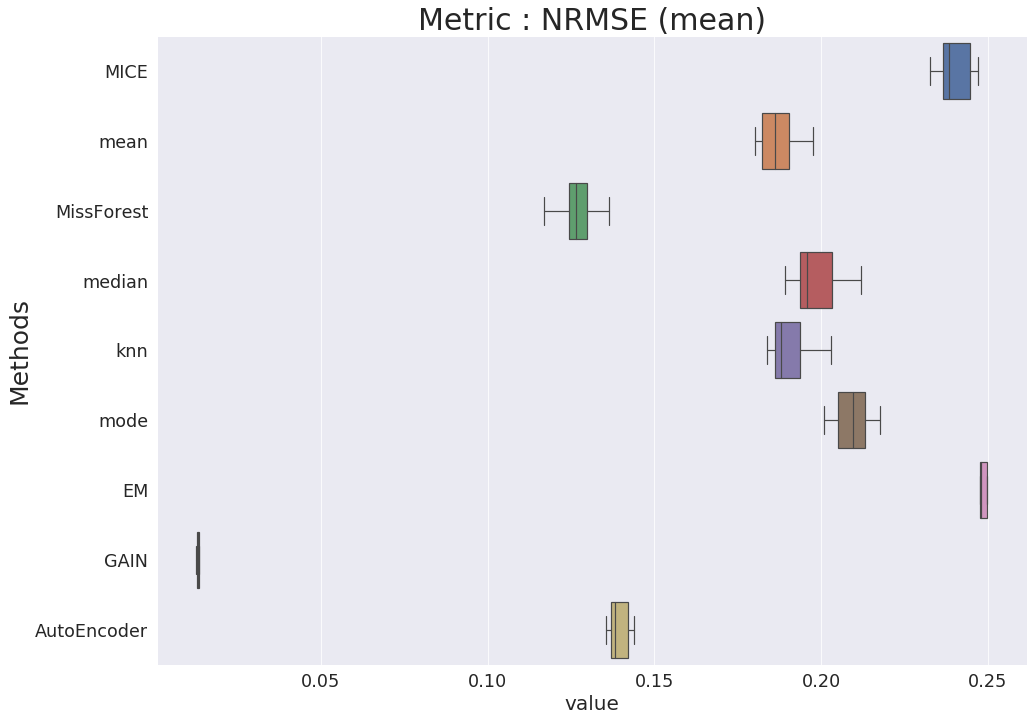

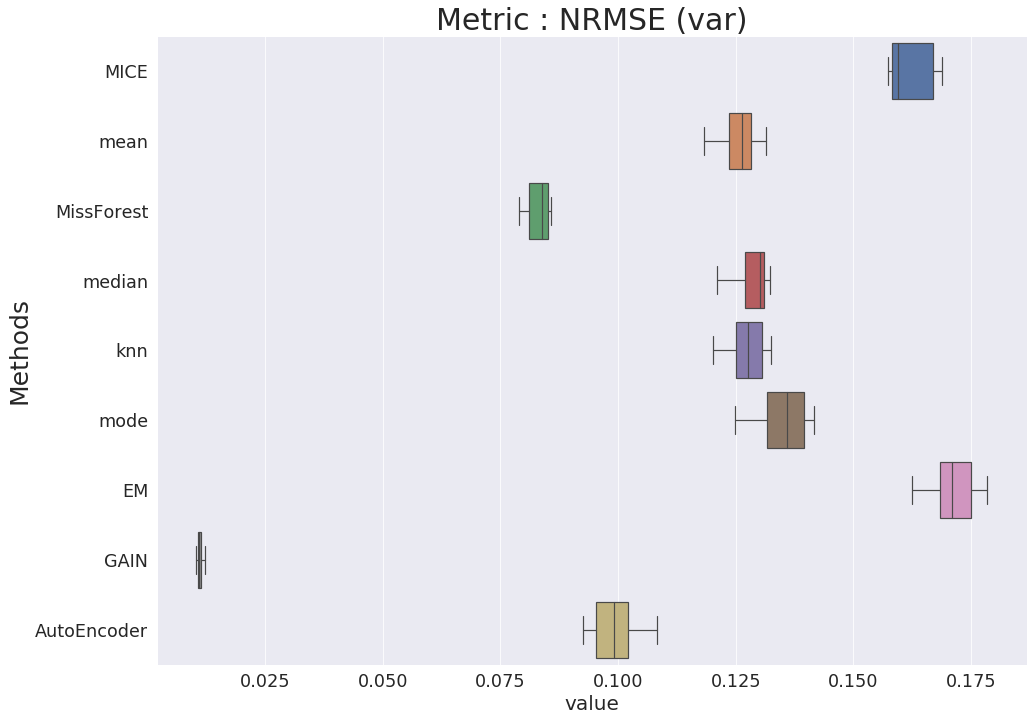

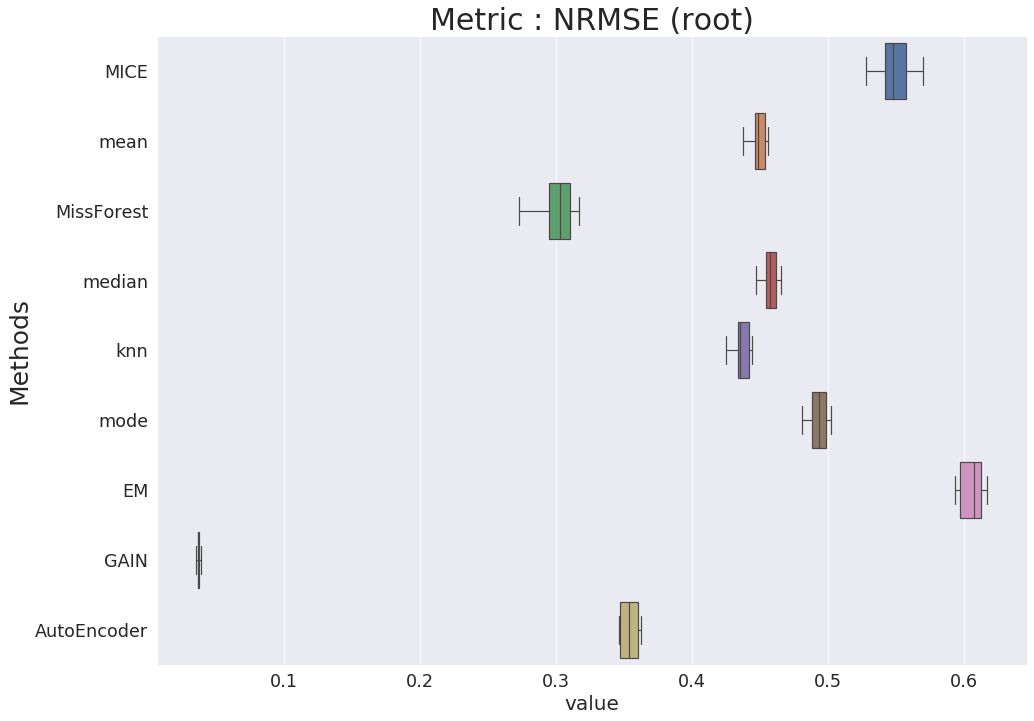

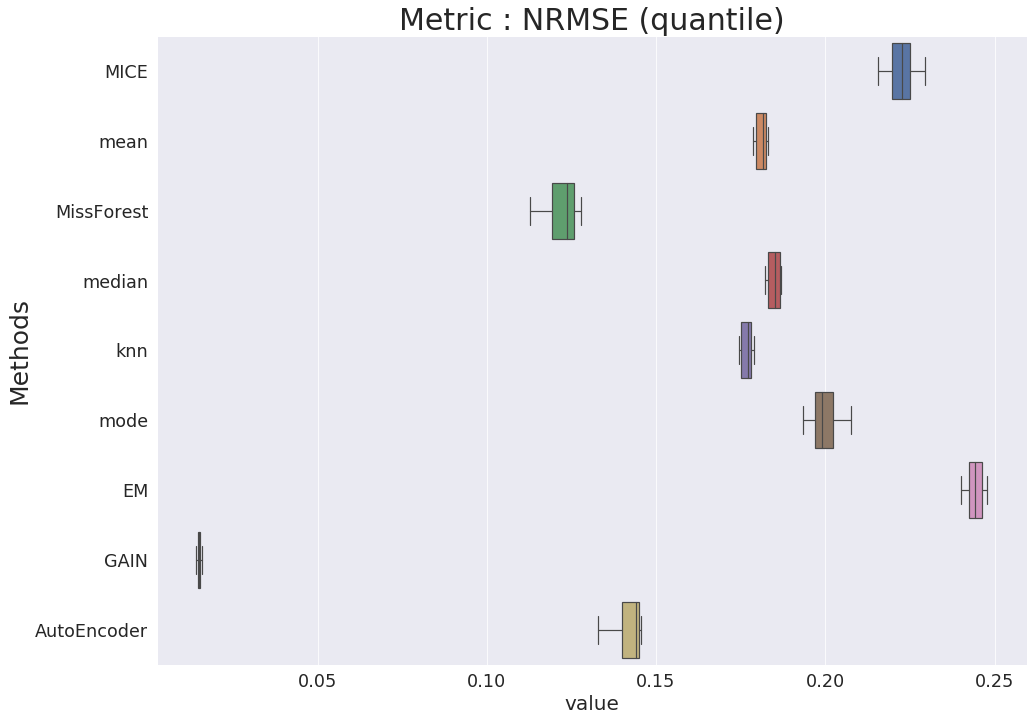

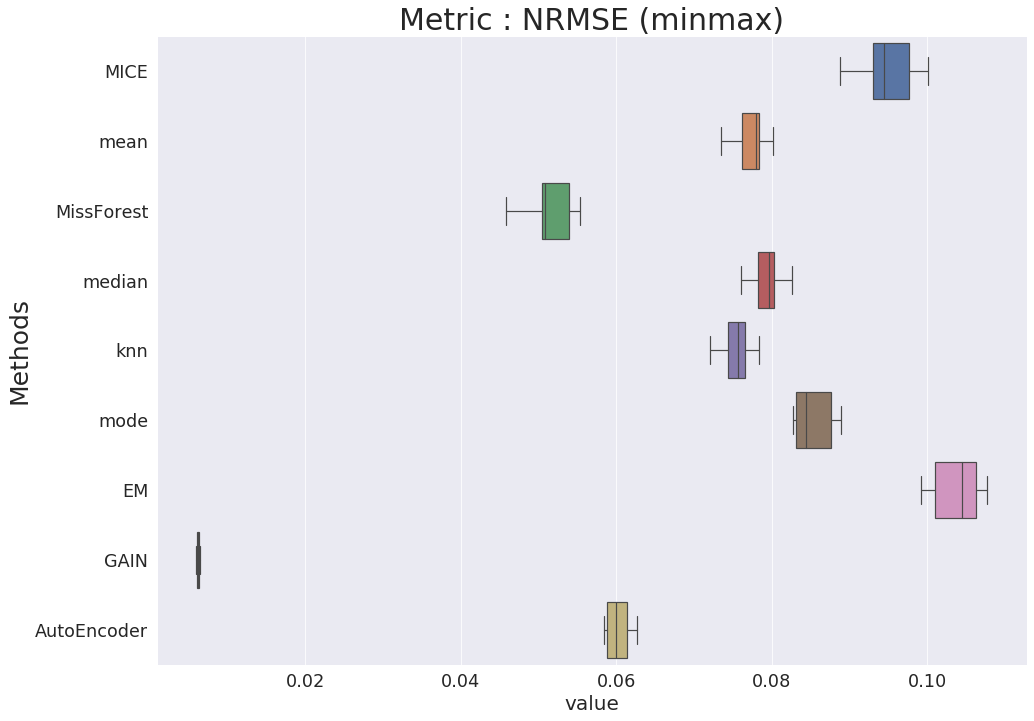

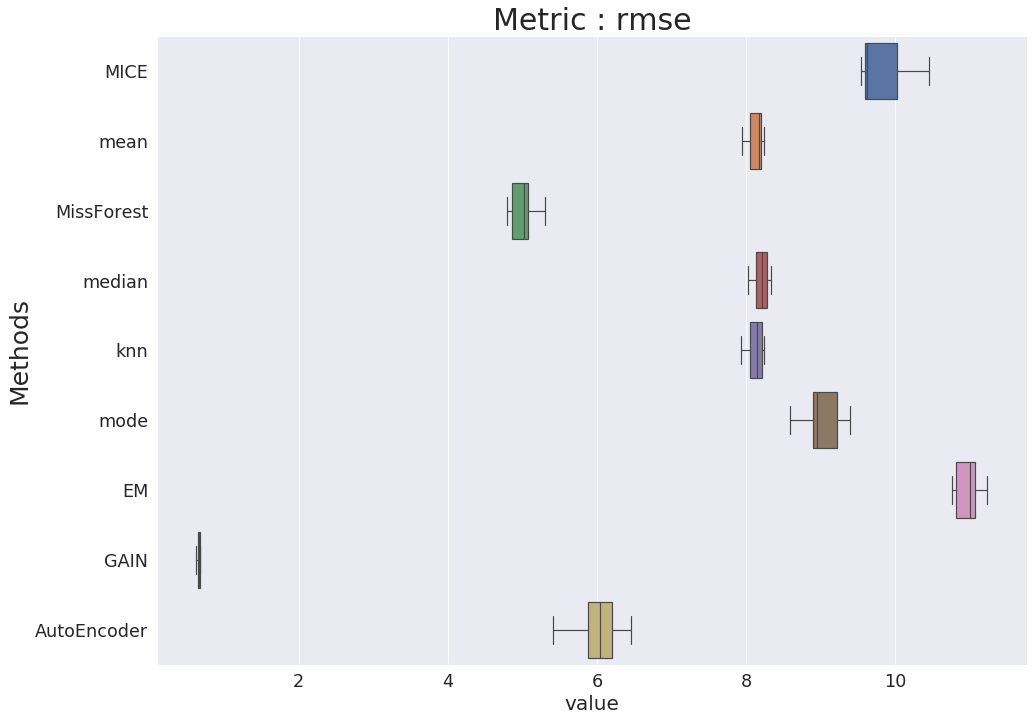

In [60]:
Imputation_BenchMark.cv_boxplot_all_run(path="./Churn_Vis_{}".format(p_miss))

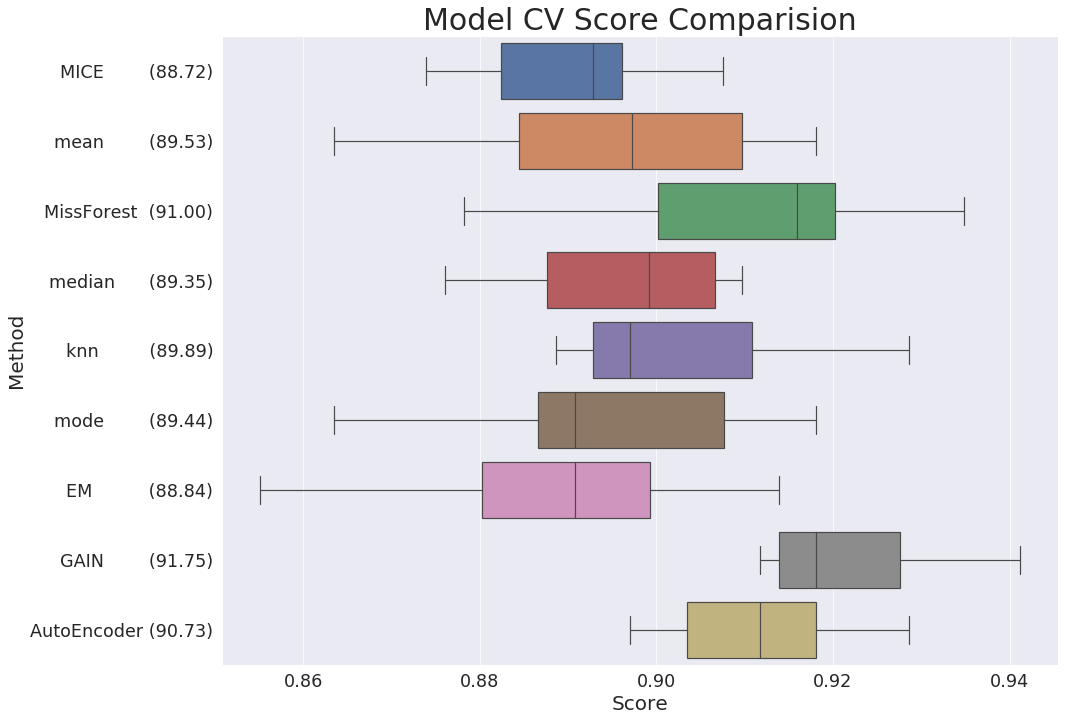

In [57]:
Imputation_BenchMark.Modeling_Measure_Vis(path = "./Churn_Vis_{}/Churn_Models_Comparision.png".format(p_miss))

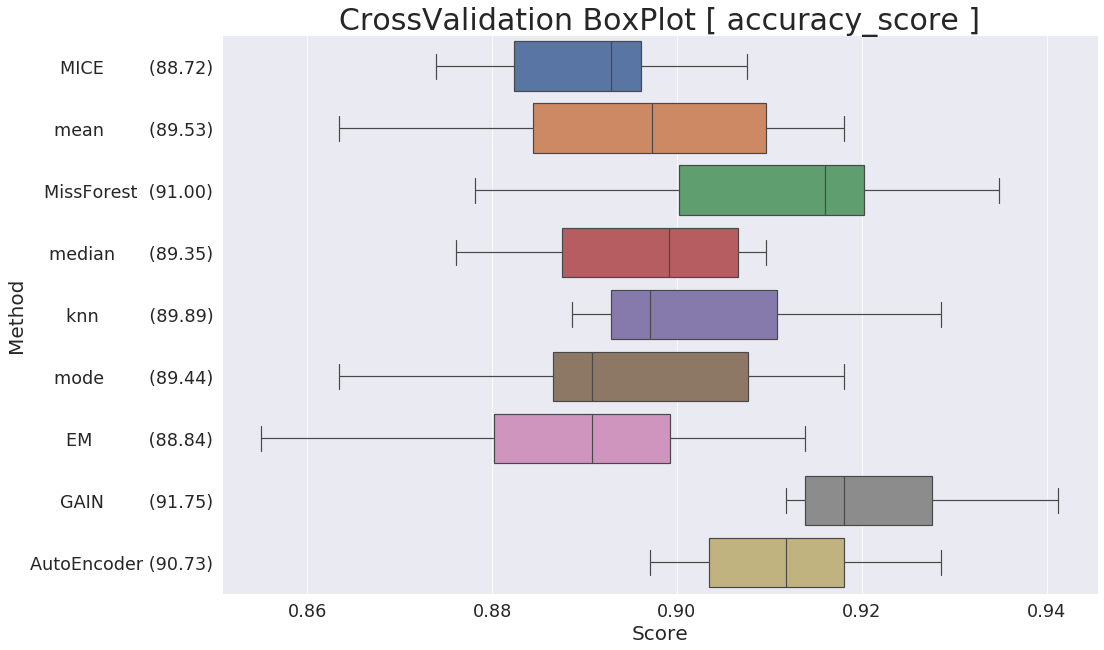

In [58]:
from sklearn.metrics import f1_score , balanced_accuracy_score as bacc , accuracy_score 
Imputation_BenchMark.Measure_Vis(accuracy_score)

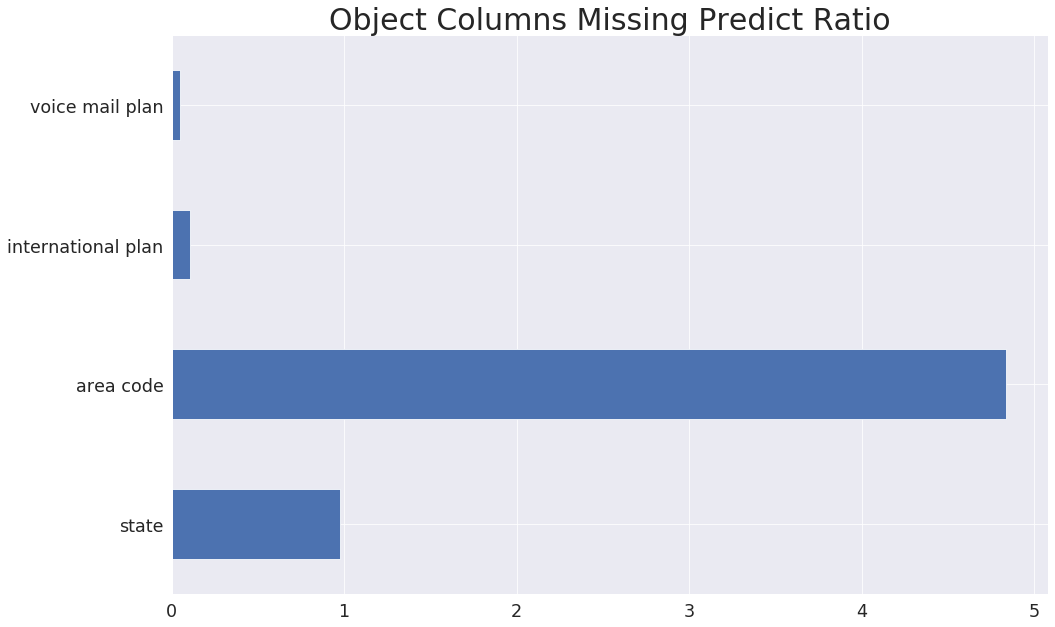

,N_not_correct,N_missing,PFC
state,657,674.0,0.974777
area code,3333,689.0,4.837446
international plan,67,635.0,0.105512
voice mail plan,33,676.0,0.048817


In [59]:
Imputation_BenchMark.Missforest_object_comparision("./")

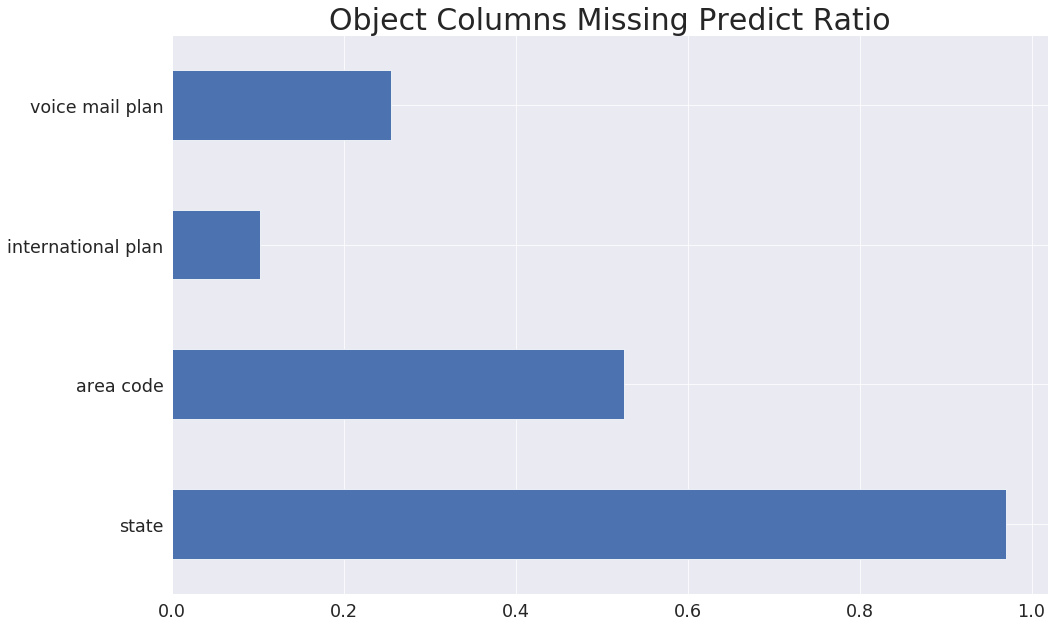

,N_not_correct,N_missing,PFC
state,654,674.0,0.970326
area code,362,689.0,0.525399
international plan,65,635.0,0.102362
voice mail plan,172,676.0,0.254438


In [50]:
Imputation_BenchMark.object_most_commom(None)

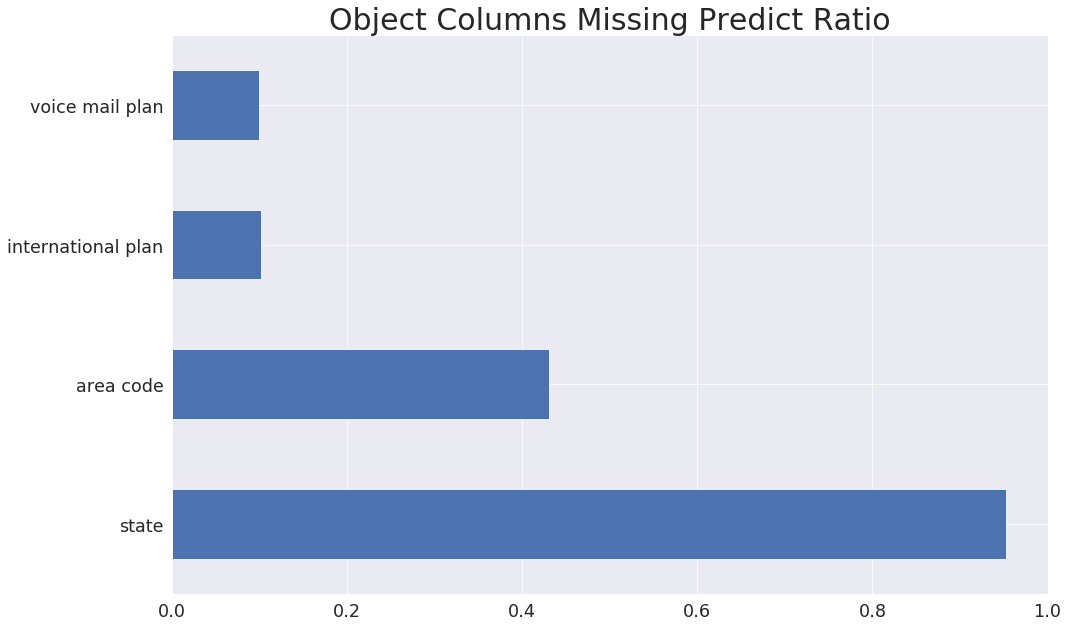

,N_not_correct,N_missing,PFC
state,642,674.0,0.952522
area code,297,689.0,0.431060
international plan,65,635.0,0.102362
voice mail plan,67,676.0,0.099112


In [51]:
Imputation_BenchMark.objectType_comparision(name="AutoEncoder", save_file_path="./")

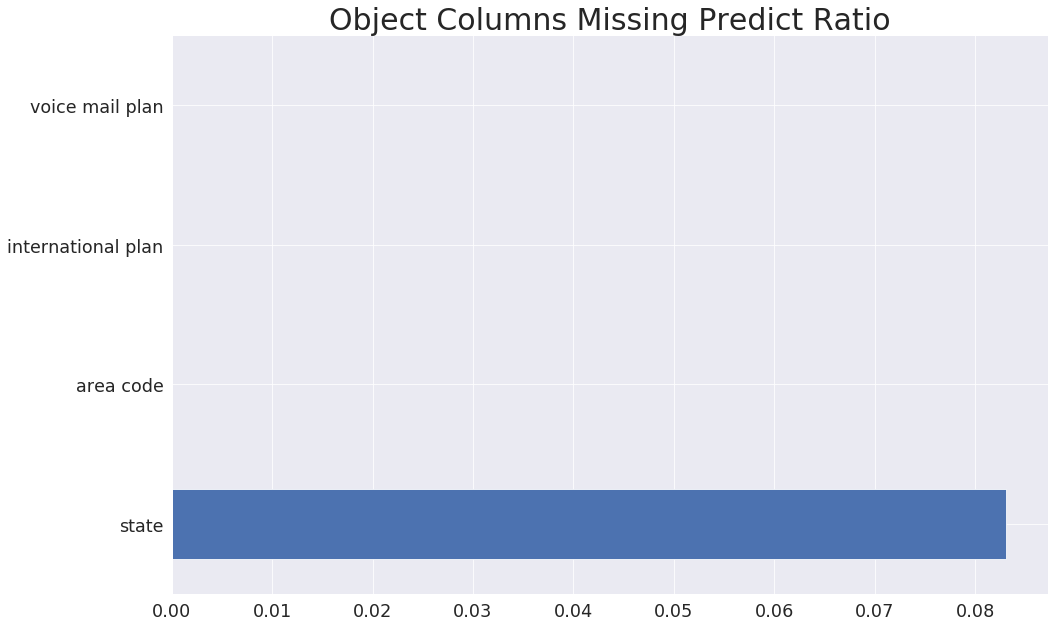

,N_not_correct,N_missing,PFC
state,56,674.0,0.083086
area code,0,689.0,0.000000
international plan,0,635.0,0.000000
voice mail plan,0,676.0,0.000000


In [52]:
Imputation_BenchMark.objectType_comparision(name="GAIN", save_file_path="./")

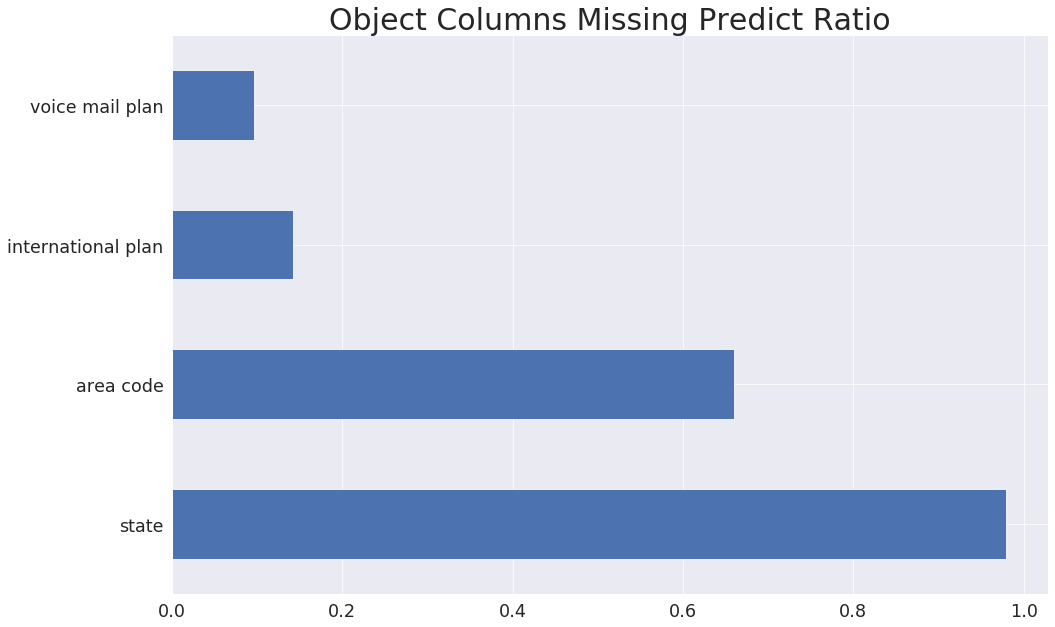

,N_not_correct,N_missing,PFC
state,660,674.0,0.979228
area code,455,689.0,0.660377
international plan,90,635.0,0.141732
voice mail plan,65,676.0,0.096154


In [53]:
# Imputation_BenchMark.MICE_object_comparison(None)
Imputation_BenchMark.objectType_comparision(name="MICE", save_file_path="./")

In [54]:
# Auto.object_comparision(RAW_TRANS , AE_load_data , target = "churn")
# mg.object_comparision(RAW_TRANS , MG_load_data, target = "churn")

In [55]:
Imputation_BenchMark.show_result(row_m= 8 , n = 2)

,algo,state,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,missing,0,0,1,0,1,0,0,1,0,0,0,1,0,1,1,1,1,0,1
1,missing,1,1,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,1
2,True,,,no,,30,0,0,10.3,0,0,0,132.8,0,5.98,13.3,7,3.59,0,False
3,True,AR,510,no,,0,0,0,25.25,146.5,0,12.45,0,83,0,0,0,0,0,False
4,MICE,,,no,,3.05364,0,0,12.1662,0,0,0,194.669,0,7.35325,12.5191,6.83988,2.51181,0,False
5,MICE,VA,408,yes,,10.6283,0,0,32.7553,195.509,0,11.8267,0,112.825,0,0,0,0,0,False
6,mean,,,no,,6.4581,0,0,30.5394,0,0,0,200.9,0,9.08362,10.2995,4.36842,2.77557,0,False
7,mean,WV,415,no,,8.22338,0,0,31.3623,198.527,0,17.2163,0,98.9868,0,0,0,0,0,False
8,MissForest,,,no,,34.3972,0,0,8.07327,0,0,0,200.332,0,9.03707,10.5899,4.39576,2.851,0,False
9,MissForest,RI,408,no,,0,0,0,25.3089,195.504,0,16.5991,0,97.2544,0,0,0,0,0,False


In [56]:
Imputation_BenchMark.save_result("./Churn_Vis_{}/Churn_Info.pkl".format(p_miss))

In [ ]:
#Imputation_BenchMark.load_result("./Churn_Vis/Churn_Info.pkl")

## Category 변수와 같이 학습을 시키면 Numeric 변수의 성능이 떨어진다....
 

In [ ]:

Imputation_BenchMark.plot(figsize = (10 , 9) , img_name="./BenchMark_Churn.png")

In [ ]:
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier as GBM
from sklearn.metrics import f1_score
import category_encoders as CatEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
Method_outcome = {}
Methods = list(Result.keys())
for Method in Methods :
    X_imp = deepcopy(Result[Method])
    XX_imp = X_imp.drop(["churn"], axis = 1)
    XXX_imp = CatEncoder.OneHotEncoder().fit_transform(XX_imp).values
    y = RAW["churn"].values
    y = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(XXX_imp , y , 
                                                        shuffle = True, 
                                                        test_size = 0.3,
                                                        stratify= y
                                                       )
    Model = GBM(max_depth= 7).fit(X = X_train , y= y_train )
    y_pred = Model.predict(X_test)
    metric = f1_score(y_test , y_pred)
    Method_outcome[Method] = metric
    print("{:11}, f1_score : {:7.5f}".format(Method , metric))


In [ ]:
from joblib import Parallel, delayed
def parallel_cv( Method ,  train_index, test_index) :
    X_imp = deepcopy(Result[Method])
    XX_imp = X_imp.drop(["churn"], axis = 1)
    XXX_imp = CatEncoder.OneHotEncoder().fit_transform(XX_imp).values
    y = LabelEncoder().fit_transform(RAW["churn"].values)
    Model = GBM(max_depth= 7).fit(X = XXX_imp[train_index , : ] , y= y[train_index] )
    y_pred = Model.predict(XXX_imp[test_index, :])
    metric = f1_score(y[test_index] , y_pred)
    return metric 

In [ ]:
list(Result.keys())

In [ ]:

Methods = list(Result.keys())

kf = KFold(n_splits = 7) # Define the split - into 2 folds 
Indexs = list(kf.split(Result["mean"]))

Method_Outcome = {}
for Method in Methods :
    X_imp = deepcopy(Result[Method])
    cv_result = (Parallel(n_jobs= kf.n_splits ,backend = "threading",prefer="threads")
                       (delayed(parallel_cv)
                        (Method , train_index, test_index) 
                        for train_index, test_index in Indexs))
    cv_f1 = np.mean(list(cv_result))
    print("{:11}, cv_f1_score : {:7.5f}".format(Method , cv_f1))
    Method_Outcome[Method] = list(cv_result)

    
    

In [ ]:
cv_melting = pd.DataFrame(Method_Outcome).melt()
cv_mean  = cv_melting.groupby(["variable"])["value"].mean()
cv_mean_value = cv_mean.values
pos = range(len(cv_mean_value))
cv_mean_label = [str(np.round(s, 2)) for s in cv_mean.values] 
sns.set(rc={'figure.figsize':(15.7,10.27) }) 
sns.set_context("paper", rc={"font.size":20,
                             "axes.titlesize":30,
                             "axes.labelsize":20},
                font_scale = 2.0
               )  
ax = sns.boxplot(y="variable", x="value", data=cv_melting)
ax.set(xlabel='F1-Score', ylabel='Method',
       title = "Model CV F1-Score Comparision")
list_ = list(ax.get_yticklabels())
xticklables_ = []
for tick , label in enumerate(list_) :
    method = label.get_text()
    value = cv_mean[method]
    xticklables_.append("{:12}({:5.2f})".format(method , value*100,3))
ax.set_yticklabels(xticklables_, rotation = 0)
plt.show()